# Spam Text Message Classification

In this final project, I'm going to do "Spam Text Message Classification" from kaggle https://www.kaggle.com/datasets/team-ai/spam-text-message-classification. This is a problem to classify messages into two categories ("span" and "ham"). I used the combination of `TfidfVectorizer` and `NMF` as unsupervised learning.

As you know, we often use `Naive Bayes Classifiers` for spam filtering. So the accuracy of the classifier is not as good as that of Naive Bayes Classifier or other supervised models. But I'll do my best to catch it up with them.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from nltk.stem import PorterStemmer 
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.simplefilter("ignore")

## Importing Data

The data has only two fields: `Category` and `Message`.

- Category: has two values "spam" and "ham".
- Message: has text or string format value.

In [2]:
path = "./text_message_data.csv"

df = pd.read_csv(path)

In [3]:
# checking data
print('train data shape: ', df.shape)
print(df.head())

train data shape:  (5572, 2)
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


## Extracting word features and show Exploratory Data Analysis (EDA)

### Checking the Number of Categories

First, we have to check the number of categories in order to know how many data rows we have at hand.

the number of spam is 747
the number of ham is 4825


<AxesSubplot:xlabel='Category', ylabel='count'>

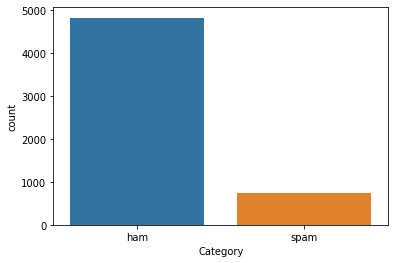

In [4]:
print("the number of spam is {}".format(sum(df["Category"]=="spam")))
print("the number of ham is {}".format(sum(df["Category"]=="ham")))
sns.countplot(x="Category", data=df)

As you can see above, we have 2 categories in the data. The number of them are unbalanced. We have to adjust the balance later.

### Removing the Suffixes (ing, ly, able...) from Words

We will use `PorterStemmer` to remove the suffixes. In order to look into the implementation, see: https://www.nltk.org/_modules/nltk/stem/porter.html.

In [5]:
ps = PorterStemmer()

df['MessageStemmed'] = df['Message'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

print('[data (raw)]', df['Message'][0])
print('[data (stemmed)]', df['MessageStemmed'][0])

[data (raw)] Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
[data (stemmed)] go until jurong point, crazy.. avail onli in bugi n great world la e buffet... cine there got amor wat...


### Removing the Punctuations (.,"'...) in Text
Here we will use `RegexpTokenizer` to remove the punctuations. For more detail: https://www.nltk.org/api/nltk.tokenize.regexp.html.

In [6]:
tokenizer = RegexpTokenizer(r'\w+')

df['MessageTokenized'] = df['MessageStemmed'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

print('[data (stemmed)]', df['MessageStemmed'][0])
print('[data (tokenized)]', df['MessageTokenized'][0])

[data (stemmed)] go until jurong point, crazy.. avail onli in bugi n great world la e buffet... cine there got amor wat...
[data (tokenized)] go until jurong point crazy avail onli in bugi n great world la e buffet cine there got amor wat


### Lowering the Words

We will convert the words to lower case.

In [7]:
df['MessageLowered'] = df['MessageTokenized'].apply(lambda x: x.lower())

print('[data (tokenized)]', df['MessageTokenized'][0])
print('[data (lowered)]', df['MessageLowered'][0])

[data (tokenized)] go until jurong point crazy avail onli in bugi n great world la e buffet cine there got amor wat
[data (lowered)] go until jurong point crazy avail onli in bugi n great world la e buffet cine there got amor wat


### Setting CategoryID for Data Processing

We have to use `number` not `string` for labels. DataFrame has a convenient function `factorize`.

In [8]:
fact = df['Category'].factorize()
print(fact)


df['CategoryId'] = fact[0]
labels = fact[1]

df.head()

(array([0, 0, 1, ..., 0, 0, 0]), Index(['ham', 'spam'], dtype='object'))


,Category,Message,MessageStemmed,MessageTokenized,MessageLowered,CategoryId
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. avail onli in b...",go until jurong point crazy avail onli in bugi...,go until jurong point crazy avail onli in bugi...,0
1,ham,Ok lar... Joking wif u oni...,ok lar... joke wif u oni...,ok lar joke wif u oni,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win fa cup fina...,free entri in 2 a wkli comp to win fa cup fina...,free entri in 2 a wkli comp to win fa cup fina...,1
3,ham,U dun say so early hor... U c already then say...,u dun say so earli hor... u c alreadi then say...,u dun say so earli hor u c alreadi then say,u dun say so earli hor u c alreadi then say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goe to usf, he live aroun...",nah i don t think he goe to usf he live around...,nah i don t think he goe to usf he live around...,0


### Adjusting the Balance of Data

We will adjust the number of two classes.

In [9]:
df_spam = df[df["Category"]=="spam"]
df_ham = df[df["Category"]=="ham"]

print("the number of spam is {}".format(df_spam.shape[0]))
print("the number of ham is {}".format(df_ham.shape[0]))

the number of spam is 747
the number of ham is 4825


We will reduce the number of ham to 747, the same as that of spam.

In [10]:
df_ham = df_ham.sample(n=df_spam.shape[0], random_state=14)
print("the number of ham is {}".format(df_ham.shape[0]))

the number of ham is 747


the number of new data is 1494


<AxesSubplot:xlabel='Category', ylabel='count'>

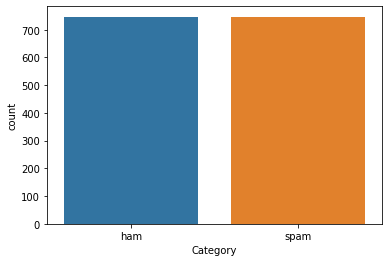

In [11]:
new_data = pd.concat([df_ham, df_spam], ignore_index=True)

print("the number of new data is {}".format(new_data.shape[0]))

sns.countplot(x="Category", data=new_data)

## Building and Training models

We use TF-IDF. 'TF' or 'term frequency' means how frequently a word appears in words. 'IDF' or 'inverse document frequence' means the log of how frequently a sentence containing a certain word apprears in all sentences. So TF-IDF is the multiplication of them.

### Train and Test Data Splitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(new_data, new_data['Category'].values, test_size=0.2, random_state=42)

In [27]:
def permutate(l, labels, label_list):
    index = list(range(0, len(label_list)))
    permu = [dict(zip(index, p)) for p in itertools.permutations(label_list)]

    max_acc = 0
    i = None

    for p in permu:
        acc = accuracy_score(l.apply(lambda x: p[x]), labels)
        if acc > max_acc:
            max_acc = acc
            i = p
    print("The Accuracy of Train Data: {}".format(max_acc))
    print(i)
    return (i, max_acc)

def iterateMinDf(data, min_df=5, n_components=2):
    l = []
    for mdf in range(1, min_df):
        # vectorize
        # this was not good: vect = CountVectorizer()
        vect = TfidfVectorizer(sublinear_tf=True, min_df=mdf, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
        X = vect.fit_transform(data)
        # NMF
        model = NMF(n_components=n_components, random_state=5)
        nmf_features = model.fit_transform(X)
        # select lable-index
        index, acc = permutate(pd.DataFrame(nmf_features).idxmax(axis=1), y_train, labels)
        # show tsne
        tsne = TSNE(n_components=n_components, random_state=0).fit_transform(X) 
        for category_id, category in sorted(index.items()):
            points = tsne[(X_train['CategoryId'] == category_id).values]
            plt.scatter(points[:, 0], points[:, 1], s=20, label=category)
        
        l.append({
            "min_df": mdf,
            "vect": vect,
            "nmf": model,
            "acc": acc,
            "index": index
        })

        plt.title("TSNE (min_df={})".format(mdf))
        plt.legend()
        plt.show()
    return l

The Accuracy of Train Data: 0.5715481171548117
{0: 'ham', 1: 'spam'}


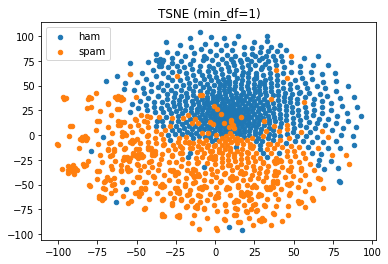

The Accuracy of Train Data: 0.9112970711297071
{0: 'spam', 1: 'ham'}


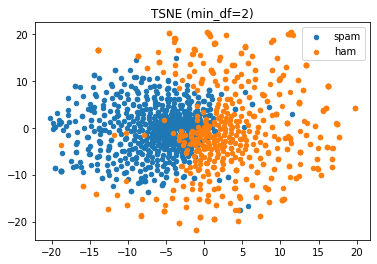

The Accuracy of Train Data: 0.8987447698744769
{0: 'spam', 1: 'ham'}


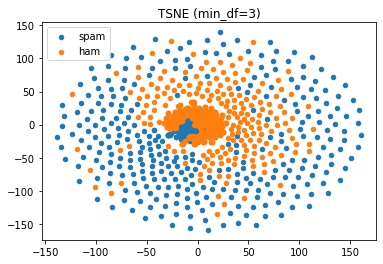

The Accuracy of Train Data: 0.8920502092050209
{0: 'spam', 1: 'ham'}


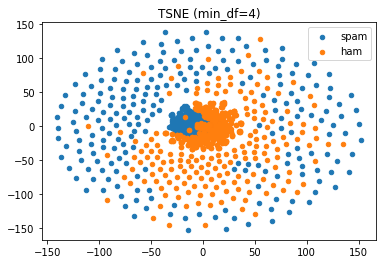

In [28]:
lst = iterateMinDf(X_train['MessageLowered'])

### Selecting the Best Model

In [29]:
best_model = max(lst, key=lambda x: x["acc"])

### Checking the Accuracy againt the Test Data

The Accuracy of Train Data: 0.9112970711297071
The Accuracy of Test Data: 0.9063545150501672


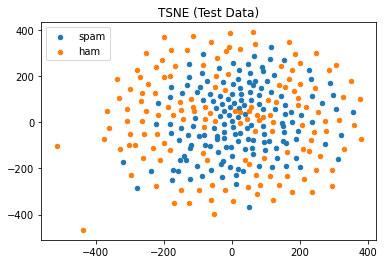

In [31]:
X = best_model["vect"].transform(X_test['MessageLowered'])
nmf_features = best_model["nmf"].transform(X)

predictions = pd.DataFrame(nmf_features).idxmax(axis=1)

acc = accuracy_score(predictions.apply(lambda x: best_model["index"][x]), y_test)
print("The Accuracy of Train Data: {}".format(best_model["acc"]))
print("The Accuracy of Test Data: {}".format(acc))

tsne = TSNE(n_components=2, random_state=0).fit_transform(X) 

for category_id, category in sorted(best_model["index"].items()):
    points = tsne[(X_test['Category'] == category).values]
    plt.scatter(points[:, 0], points[:, 1], s=20, label=category)

plt.title("TSNE (Test Data)")
plt.legend()
plt.show()

As you can see above, the messages are classified into two categories at the accuracy of `0.9063` againt the test data.

## Compare with Supervised Learning

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=10),
    MultinomialNB(),
    LogisticRegression(random_state=10),
]

CV = 5
X = best_model["vect"].transform(X_train['MessageLowered'])
cross_val = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X.toarray(), y_train, scoring='accuracy', cv=CV)
    for idx, accuracy in enumerate(accuracies):
        entries.append((model_name, idx+1, accuracy))

cross_val = pd.DataFrame(entries, columns=['model_name', 'idx', 'accuracy'])

                model_name  idx  accuracy
0   RandomForestClassifier    1  0.912134
1   RandomForestClassifier    2  0.916318
2   RandomForestClassifier    3  0.887029
3   RandomForestClassifier    4  0.849372
4   RandomForestClassifier    5  0.836820
5            MultinomialNB    1  0.949791
6            MultinomialNB    2  0.941423
7            MultinomialNB    3  0.937238
8            MultinomialNB    4  0.941423
9            MultinomialNB    5  0.933054
10      LogisticRegression    1  0.958159
11      LogisticRegression    2  0.966527
12      LogisticRegression    3  0.962343
13      LogisticRegression    4  0.958159
14      LogisticRegression    5  0.958159


<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

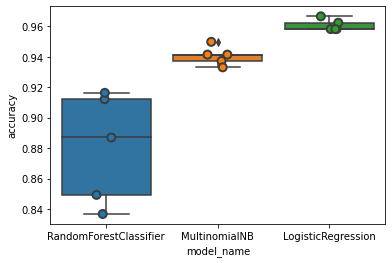

In [33]:
print(cross_val)
sns.boxplot(x='model_name', y='accuracy', data=cross_val)
sns.stripplot(x='model_name', y='accuracy', data=cross_val, size=8, jitter=True, edgecolor="gray", linewidth=2)

The max accuracy of supervised models are `0.9665` from the third model of `LogisticRegression`. That of our unsupervised model is `0.9063`, which is not as good as that of the supervised model.

## Conclusion

As we expected from the start, the unsupervised model using `NMF` was not as good as other supervied models. But its accuracy against the test data (unknown data) was `0.9063`, which I thought was high enough for practical use.